#               Machine Learning with SFE dataset for alloy design

This notebook discusses the complete workflow for using SFE data of steels and doing visualization, learning with the training dataset and prediction on untested alloy compositions which could be potentially super useful in alloy design. Various statistical algorithms have been deployed for robust visualization and classification of the SFE dataset.

In [1]:
# Loading all required dependencies and packages

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import IPython
print("IPython: ", IPython.__version__)

import csv
print("csv: ", csv.__version__)

import pandas as pd
print("pandas: ", pd.__version__)

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib: ", matplotlib.__version__)

import numpy as np
print("numpy: ", np.__version__)

import sklearn
print("Scikit Learn: ", sklearn.__version__)
import math
import pylab
import time
import pprint as pp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from IPython.display import Image
from __future__ import division

('IPython: ', '4.0.2')
('csv: ', '1.0')
('pandas: ', u'0.17.1')
('matplotlib: ', '1.5.0')
('numpy: ', '1.10.1')
('Scikit Learn: ', '0.17')


### Loading dataset using Pandas

Below we load our *Final SFE Data* file using *_Pandas_* package. We also set some display settings and get a preview of what data is in our file, as well as see all the column headers we have.

In [2]:
#setting display options for pandas dataframe outputs
pd.options.display.max_columns = 50
pd.options.display.max_rows = 300

#ini_dataset is the as-is load of the sfe data without any processing
ini_dataset = pd.read_csv('Final SFE Data.csv', delimiter =',',index_col = None, header = 0)
colheaders = list(ini_dataset.columns.values)

print colheaders
print "\n"
print ini_dataset.head(2)

['C', 'N', 'P', 'S', 'V', 'Ni', 'Nb', 'Al', 'Ti', 'Fe', 'Hf', 'Mo', 'Mn', 'Co', 'Si', 'Cr', 'Cu', 'DOI', 'url', 'SFE', 'Error', 'title', 'Author', 'temperature', 'experiment_type']


       C      N      P      S  V    Ni  Nb  Al  Ti      Fe  Hf   Mo    Mn  Co  \
0  0.004  0.003  0.025  0.001  0  15.6   0   0   0  64.317   0  2.5  0.03   0   
1  0.020  0.009  0.022  0.001  0  15.6   0   0   0  64.188   0  2.5  0.03   0   

     Si    Cr  Cu                        DOI  \
0  0.02  17.5   0  10.1007/s11661-013-1943-0   
1  0.03  17.6   0  10.1007/s11661-013-1943-0   

                                                 url   SFE     Error  \
0  http://link.springer.com/article/10.1007/s1166...  51.6  0.014341   
1  http://link.springer.com/article/10.1007/s1166...  54.6  0.023810   

                                               title            Author  \
0  The Effect of Chemical Composition and Heat Tr...  Yonezawa, Toshio   
1  The Effect of Chemical Composition and Heat Tr...  Yonezawa,

## Data Pre-processing

Below we will load all the SFE data from the csv file and then do a series of pre-processing steps like choosing a subset of the data appropriate for analysis and do certain transformations. The name of different dataset variables are explained as we go through with the analysis. 

#### Selecting measurements done only on room temperature.

As you will see below, the dataset has primarily measurements taken at room temperature. Thus the dataset is heavily biased for measurements at a certain factor and it would be unadvisable to model using temperature as a predictor. Further, for the purpose of alloy design applications a prediction at room temperature would suffice for practical applications. Hence we choose a subset of the initial dataset with only room temperature measurements. Thus *ini_dataset_1* is the subset of *ini_dataset* with only room temperature measurements.

In [3]:
print "There are total %d observations in the dataset" %len(ini_dataset)

print "There are total %d observations in the dataset that are room temperature measurements"% \
len(ini_dataset[(ini_dataset.temperature>290) & (ini_dataset.temperature<310)])

#the subset with room temperature measurments
ini_dataset_1 = ini_dataset[(ini_dataset.temperature>290) & (ini_dataset.temperature<310)]

print "There are total %d observations in the room temp dataset" %len(ini_dataset_1)

There are total 473 observations in the dataset
There are total 426 observations in the dataset that are room temperature measurements
There are total 426 observations in the room temp dataset


#### Selecting measurements from only experiments.

When we started with the data compilation we were planning to use all (computational and experimental) SFE data in the literature. However as we read through the literature we decided to use only experimental measurements for our analysis as these are the only "truth" values. However we left the already collected values in the original dataset. Thus below we subset our data by selecting only experimental measurements. Thus *ini_dataset_2* is the subset of *ini_dataset_1* with only experimental measurements. We also drop columns *url* and *doi* from our dataset as they are not needed for the analysis.

In [4]:
#displaying different experiment types in our dataset
print ini_dataset_1.experiment_type.unique()

['TEM - WBDF' 'XRD' 'TEM' 'Thermodynamic Modeling' 'Synchrotron XRD'
 'TEM-WBDF' 'Neutron Diffraction' 'Literature Review' 'Literature review']


In [5]:
len(ini_dataset_1[ini_dataset_1.experiment_type != 'Thermodynamic Modeling'])

387

In [6]:
#ini_dataset_2 is the next subset with only experimental values
ini_dataset_2 = ini_dataset_1[ini_dataset_1.experiment_type != 'Thermodynamic Modeling']
print len(ini_dataset_2), "\n"

#dropping columns url and doi
print ini_dataset_2.columns.values
print len(ini_dataset_2.columns.values)
print ini_dataset_2.columns[[17,18]], "\n"
ini_dataset_2 = ini_dataset_2.drop(['DOI','url'],axis=1)
print ini_dataset_2.columns.values
print len(ini_dataset_2.columns.values)

387 

['C' 'N' 'P' 'S' 'V' 'Ni' 'Nb' 'Al' 'Ti' 'Fe' 'Hf' 'Mo' 'Mn' 'Co' 'Si' 'Cr'
 'Cu' 'DOI' 'url' 'SFE' 'Error' 'title' 'Author' 'temperature'
 'experiment_type']
25
Index([u'DOI', u'url'], dtype='object') 

['C' 'N' 'P' 'S' 'V' 'Ni' 'Nb' 'Al' 'Ti' 'Fe' 'Hf' 'Mo' 'Mn' 'Co' 'Si' 'Cr'
 'Cu' 'SFE' 'Error' 'title' 'Author' 'temperature' 'experiment_type']
23


**ini_dataset_3 is the next subset of dataset with only ferrous alloys** We had a few measuremnts in our dataset which were essentially nickel based alloys and since our population is very different from that, we drop the measurements to have only a dataset for ferrous alloys. Notice we have dropped measurements of a certain author as we precisely knew these were the only ones not of ferrous alloys.

In [7]:
print len(ini_dataset_2)
print len(ini_dataset_2[ini_dataset_2.Author != 'Unfried-Silgado, Jimy'])

ini_dataset_3 = ini_dataset_2[ini_dataset_2.Author != 'Unfried-Silgado, Jimy']
print len (ini_dataset_3)

387
379
379


**Selecting predictor variables**

Below we notice that there are many column headers for different element-alloying additions in the dataset. However there are 2 scenarios:

1) There are very very few measurements for certain alloying additions. For example Nb, Hf, Co, Cu, V, Ti (see below - second column) where there are only a few(or none) alloys containing these additions for which SFE measurements have been done in our subset of initial dataset.

2) They are very few measurements where the elements are substantial alloying additions and not because of impurity or trace additions. Eg. P, S (see below - third column)

We will need to drop all these elements from model as there is not enough data to consider them as factors.

In [8]:
colheaders_2 = ['C','N','P','S','V','Ni','Nb','Mn','Al','Ti','Fe','Hf','Mo','Co','Si','Cr','Cu']

#checking for measurements where alloying additions are 1) existing 2) beyond a certain value
for item in colheaders_2 :
    print  item, len(ini_dataset_3[ini_dataset_3[item]> 0]), len(ini_dataset_3[ini_dataset_3[item]> 0.05])


C 339 98
N 248 85
P 170 7
S 170 1
V 0 0
Ni 300 300
Nb 2 2
Mn 305 217
Al 34 27
Ti 0 0
Fe 379 379
Hf 0 0
Mo 168 133
Co 3 3
Si 240 120
Cr 332 332
Cu 6 6


In [9]:
colheaders_3 = ['Nb','Co','Cu']
for item in colheaders_3 :
    print  item, len(ini_dataset_3[ini_dataset_3[item] > 0.05])


Nb 2
Co 3
Cu 6


In [10]:
#checking for measurements with specifically the above 3 elements (Nb, Co, Cu)

ini_dataset_3[(ini_dataset_3.Nb> 0.05) | (ini_dataset_3.Co> 0.05) | (ini_dataset_3.Cu>0.05)][[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,]]

,C,N,P,S,V,Ni,Nb,Al,Ti,Fe,Hf,Mo,Mn,Co,Si,Cr,Cu,SFE,Error,Author
117,0.047,0.205,0.00,0.000,0,3.71,0.00,0,0,71.218,0,0.05,6.74,0.00,0.32,17.48,0.23,13.20,0.000000,"Barman, H."
132,0.047,0.205,0.00,0.000,0,3.71,0.00,0,0,71.218,0,0.05,6.74,0.00,0.32,17.48,0.23,15.84,0.000000,"Barman, H."
237,0.041,0.054,0.00,0.000,0,8.10,0.00,0,0,70.875,0,0.32,1.71,0.00,0.33,18.20,0.37,17.80,0.067416,"Talonen, J."
238,0.019,0.094,0.00,0.000,0,6.60,0.00,0,0,73.237,0,0.14,1.61,0.00,0.48,17.60,0.22,12.80,0.117188,"Talonen, J."
239,0.017,0.145,0.00,0.000,0,6.60,0.00,0,0,73.698,0,0.15,1.34,0.00,0.51,17.40,0.14,14.70,0.054422,"Talonen, J."
256,0.023,0.000,0.00,0.000,0,8.59,0.00,0,0,66.667,0,0.00,0.15,6.42,0.19,17.96,0.00,11.50,0.000000,"Dulieu, D."
257,0.115,0.000,0.00,0.000,0,10.04,0.00,0,0,66.525,0,0.00,0.22,0.00,0.10,17.80,5.20,63.25,0.090900,"Dulieu, D."
335,0.006,0.007,0.01,0.014,0,15.00,0.00,0,0,49.420,0,0.00,0.04,20.20,0.00,15.30,0.00,27.60,0.000000,"Silcock, J.M."
339,0.000,0.000,0.00,0.000,0,10.10,0.00,0,0,64.350,0,0.00,0.00,9.55,0.00,16.00,0.00,18.40,0.000000,"Silcock, J.M."
351,0.014,0.004,0.00,0.000,0,20.00,1.00,0,0,58.982,0,0.00,0.00,0.00,0.00,20.00,0.00,17.25,0.000000,"Douglass, D.L."


##### ini_dataset_4 is the next subset of dataset with only values along the 9 chosen elements with enough datapoints

In [11]:
ini_dataset_4 = ini_dataset_3[(ini_dataset_3.Nb< 1) & (ini_dataset_3.Co< 1) & (ini_dataset_3.Cu< 1)]
len(ini_dataset_4)

374

In [12]:
ini_dataset_4 = ini_dataset_4.drop(['P','S','V','Ti','Hf','Nb','Co','Cu'],axis=1)
print ini_dataset_4.columns.values
print len(ini_dataset_4.columns.values)

['C' 'N' 'Ni' 'Al' 'Fe' 'Mo' 'Mn' 'Si' 'Cr' 'SFE' 'Error' 'title' 'Author'
 'temperature' 'experiment_type']
15


In [13]:
index = range(1,len(ini_dataset_4)+1)

#ini_dataset_5 is a another dataframe to make some format changes and let ini_dataset_4 be as-is
ini_dataset_5 = ini_dataset_4
print len(ini_dataset_5)
ini_dataset_5.insert(0,'sno',index)

374


In [14]:
ini_dataset_5 = ini_dataset_5.set_index(['sno'])
#display preview of final dataframe
ini_dataset_5.head()

,C,N,Ni,Al,Fe,Mo,Mn,Si,Cr,SFE,Error,title,Author,temperature,experiment_type
sno,,,,,,,,,,,,,,,
1,0.004,0.003,15.6,0,64.317,2.5,0.03,0.02,17.5,51.6,0.014341,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
2,0.020,0.009,15.6,0,64.188,2.5,0.03,0.03,17.6,54.6,0.023810,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
3,0.020,0.002,14.0,0,66.409,2.4,0.03,0.01,17.1,50.3,0.023062,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
4,0.005,0.001,15.6,0,63.866,2.6,0.19,0.01,17.7,52.8,0.012879,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF
5,0.016,0.008,10.8,0,68.899,0.3,0.85,0.10,19.0,35.0,0.023429,The Effect of Chemical Composition and Heat Tr...,"Yonezawa, Toshio",300,TEM - WBDF


**Converting dataframe to array** to work with numpy based packages.

In [15]:
ini_array = ini_dataset_5.reset_index().values
print ini_array.shape
print ini_array[0,:]

(374L, 16L)
[1L 0.004 0.003 15.6 0.0 64.317 2.5 0.03 0.02 17.5 51.6 0.014341085
 'The Effect of Chemical Composition and Heat Treatment Conditions on Stacking Fault Energy for Fe-Cr-Ni Austenitic Stainless Steel'
 'Yonezawa, Toshio' 300L 'TEM - WBDF']


In [16]:
#subsetting the array to include only numerical values needed for analysis
SFEdata = ini_array[:,0:12]
SFEdata = np.array(SFEdata, dtype='float')

#constructing a band of SFE values based on error bars (SFE low and SFE high)
low = SFEdata[:,10]*(1 - SFEdata[:,11])
high = SFEdata[:,10]*(1 + SFEdata[:,11])
lowhigh = np.column_stack((low,high))

In [17]:
#adding the SFE band columns to the array
SFEdata = np.column_stack((SFEdata,lowhigh))
print SFEdata.shape
print SFEdata[0,:]

(374L, 14L)
[  1.00000000e+00   4.00000000e-03   3.00000000e-03   1.56000000e+01
   0.00000000e+00   6.43170000e+01   2.50000000e+00   3.00000000e-02
   2.00000000e-02   1.75000000e+01   5.16000000e+01   1.43410850e-02
   5.08600000e+01   5.23400000e+01]


**Creating SFE classes from SFE values**

One very important aspect of this analysis is to discretize/bin our SFE data which is numerical and continuous into 3 classes. The 3 classes are *High*, *Medium* and *Low* have been chosen in accordance with literature corressponding to different generally observed deformation regimes given different SFE values.

1. High - SFE > 45 $mJ/m^2$
2. Medium - 20 $mJ/m^2$ < SFE < 45 $mJ/m^2$
3. Low - SFE < 20 $mJ/m^2$

The origins and justification of such a discretization can be read more in our journal paper of this analysis.

In [20]:
#determining class based on SFE value

SFEclass = np.zeros(SFEdata.shape[0])

SFEclass[SFEdata[:,10] <= 20] = 1
SFEclass[(SFEdata[:,10] > 20) & (SFEdata[:,10] <= 45)] = 2
SFEclass[(SFEdata[:,10] > 45)] = 3

#check number of entries for each class 
print((SFEclass == 1).sum())
print((SFEclass == 2).sum())
print((SFEclass == 3).sum())

#check if only the needed classes there
print (SFEclass == 1).sum() + (SFEclass == 2).sum() + (SFEclass == 3).sum() 
print SFEclass.shape
print SFEdata.shape

77
209
88
374
(374L,)
(374L, 14L)


## Data Visualization

We now aim to visualize the SFE data and look for any patterns possible in the raw data itself.

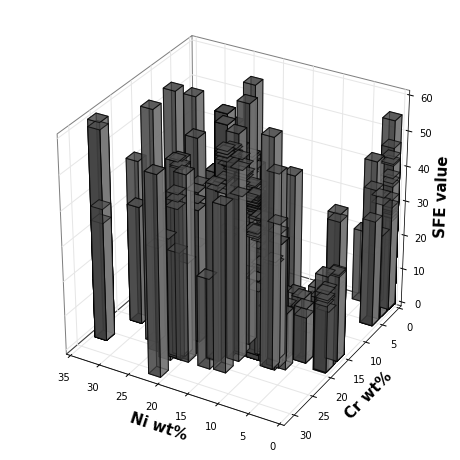

In [22]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.bar3d(SFEdata[SFEdata[:,10]<70,3],SFEdata[SFEdata[:,10]<70,9],
         np.zeros(SFEdata[SFEdata[:,10]<70,:].shape[0]),2,2,SFEdata[SFEdata[:,10]<70,10],
         edgecolor='black', color='grey', alpha=0.7)
ax.set_xlabel("Ni wt%", fontsize=15, fontweight='heavy')
ax.set_xlim(35,0)
ax.set_ylabel("Cr wt%", fontsize=15, fontweight='heavy')
ax.set_ylim(32,0)
ax.set_zlabel("SFE value", fontsize=15, fontweight='heavy')
ax.set_zlim(0,60)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#ax.view_init(15,120)

#plt.savefig('Ni-Cr.png',format='png',dpi=500)

What we see above is the dependence of SFE on 2 different elements - *Ni* and *Cr*. What the above graph is depicting is the non-linear dependence of SFE on both these elements. One cannot just say what is the effect of increasing or decreasing any of the elements on SFE as it depends on what the values of other elements are. Thus we give the first evidence that general rules of thumb like increasing a certain element's value can lead to a certain behavior in SFE can't be applied.

In [23]:
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

**Visualizing variation of SFE with every element**

Below we plot the different trends of SFE values varying with different % alloying additions. The different colored points are:

1. Green - *High* SFE values
2. Red - *Medium* SFE values
3. Blue - *Low* SFE values

If there is some true trend, one should observe separation of these differently colored points with different compositional values.

In [24]:
Elements = SFEdata[:,:10]
print Elements.shape
Elementlist=ini_dataset_5.columns.values[0:9]
print Elementlist

(374L, 10L)
['C' 'N' 'Ni' 'Al' 'Fe' 'Mo' 'Mn' 'Si' 'Cr']


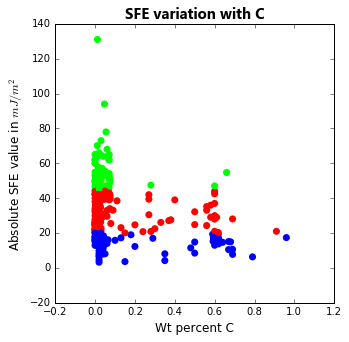

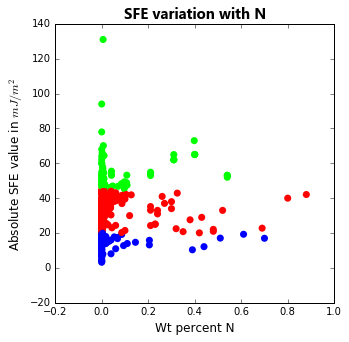

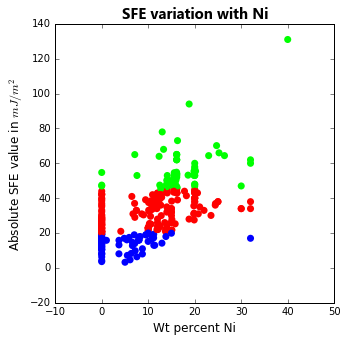

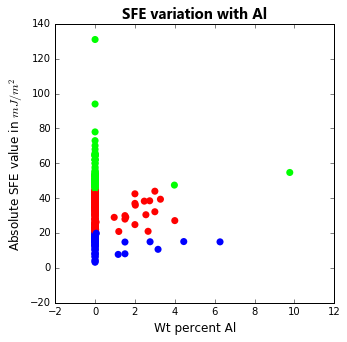

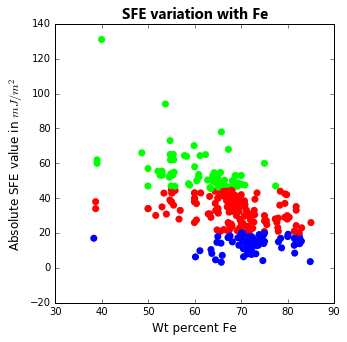

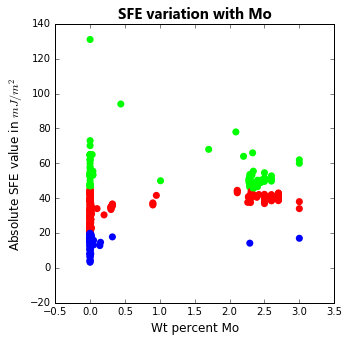

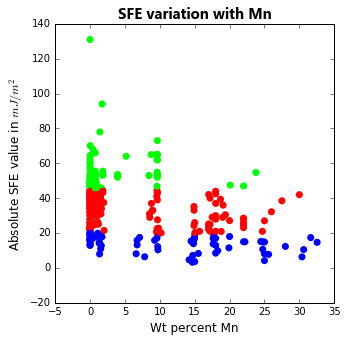

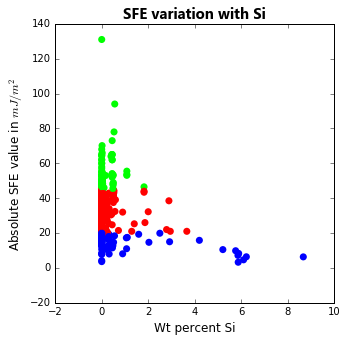

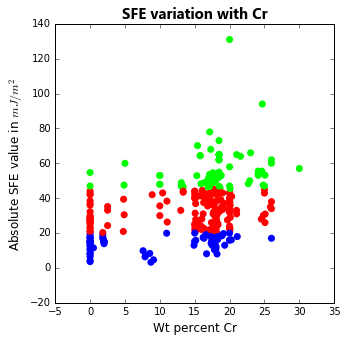

In [26]:
for i in range(1,10):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(Elements[:,i],SFEdata[:,10],c=SFEclass,marker="o", s=50, edgecolor='',cmap ='brg')
    ax.set_xlabel("Wt percent %s"%Elementlist[i-1],fontsize=12, fontweight='normal')
    ax.set_ylabel("Absolute SFE value in $mJ/m^2$",fontsize=12, fontweight='normal')
    ax.set_title("SFE variation with %s"%Elementlist[i-1], fontweight='bold', fontsize=15, fontname='Segoe UI')
    #plt.savefig("Figure1_{y}.png".format(y=Elementlist[i-1]),dpi=500)

As evident from the plots above, there is no clear trend (linear or non-linear) of dependence of SFE on any specific element's composition. For same value of alloying addition, one can see a range of SFE values and (SFE classes), clearly eliciting a highly non-linear dependence and interaction effects of the elements on SFE.

**Visualizing variaton of SFE with two elements**

Below we plot different SFE classes (high, medium, low) with variation in 2 elements simultaneuouly. We are looking to find patterns in the below plots to see if there are any combination of elements that for sure lead to a certain SFE class.

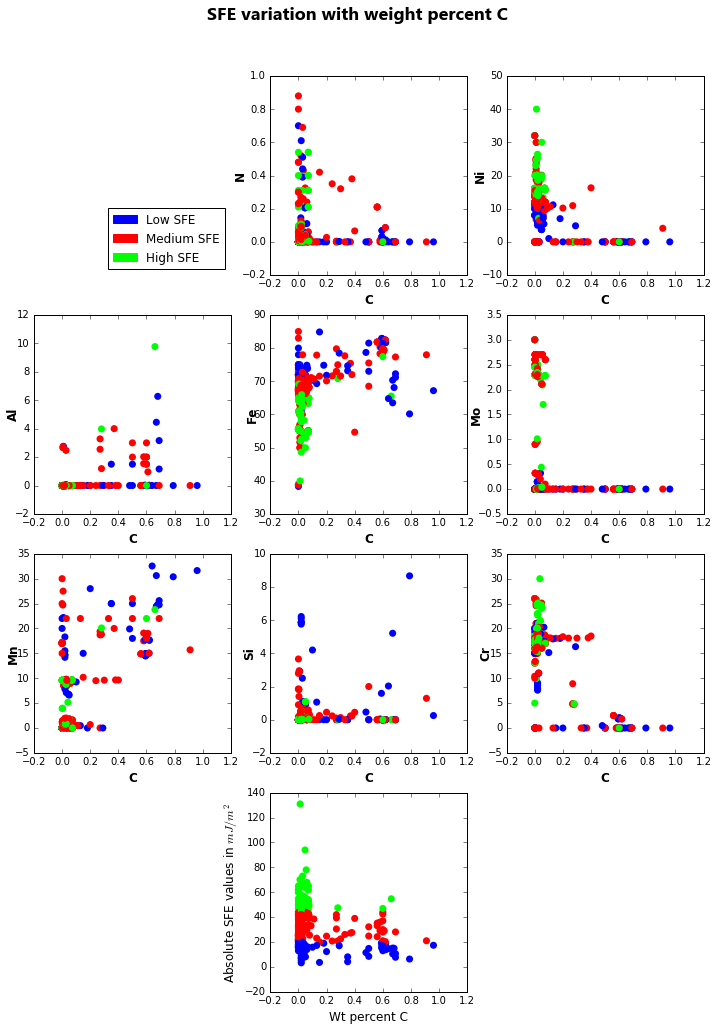

In [27]:
iterarr1= range(1,2)
iterarr = range(1,10)
for j in iterarr1:
    fig = plt.figure(figsize=(12,16))
    fig.suptitle("SFE variation with weight percent %s"%Elementlist[j-1], fontweight='bold', fontsize=18, fontname='Segoe UI')
    plt.subplots_adjust(top=.92)
    for i in iterarr:
        ax = fig.add_subplot(4,3,i)
        if (i!=j):
            cax = ax.scatter(Elements[:,j],Elements[:,i], c=SFEclass, marker="o", s=50, edgecolor='', cmap ='brg')
            ax.set_xlabel(Elementlist[j-1],fontsize=12, fontweight='bold')
            ax.xaxis.labelpad = 5
            ax.set_ylabel(Elementlist[i-1],fontsize=12, fontweight='bold')
            ax.yaxis.labelpad = -5
        else:
            #fig.colorbar(cax)
            blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
            red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
            green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')
            plt.axis('off')
            ax.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower right')
    ax = fig.add_subplot(4,3,11)        
    ax.scatter(Elements[:,j],SFEdata[:,10], c=SFEclass, marker="o", s=50, edgecolor='', cmap ='brg')
    ax.set_xlabel("Wt percent %s"%Elementlist[j-1],fontsize=12, fontweight='normal')
    ax.set_ylabel("Absolute SFE values in $mJ/m^2$",fontsize=12, fontweight='normal')
    #plt.savefig("Figure1_{y}.png".format(y=Elementlist[j-1]),dpi=500)

In the above plots, we see that there is no particular combination of *C* and any other element which leads to separation of any of the classes of SFE with all points being mixed in there. If anything, one can notice that with increasing %C there aren't any high SFE classes. This can due to an effect of *C* or because of the compositions themselves that have higher *C* in them.

In [29]:
#sandbox cell for checking values of interest (This is based after seeing other plots in the analysis)
ini_dataset_5[(ini_dataset_5.Mo > 2)&(ini_dataset_5.SFE < 20)]

,C,N,Ni,Al,Fe,Mo,Mn,Si,Cr,SFE,Error,title,Author,temperature,experiment_type
sno,,,,,,,,,,,,,,,
55,0.015,0.0193,12.95,0,65.6457,2.29,1.3,0.43,17.35,14.2,0,Weak Beam TEM Study on Stacking Fault Energy o...,"Ojima, M.",300,TEM
66,0.000,0.7000,32.00,0,38.3000,3.00,0.0,0.00,26.00,17.0,0,Orientation dependence of resolved shear stres...,"Kireeva, I. V.",300,TEM


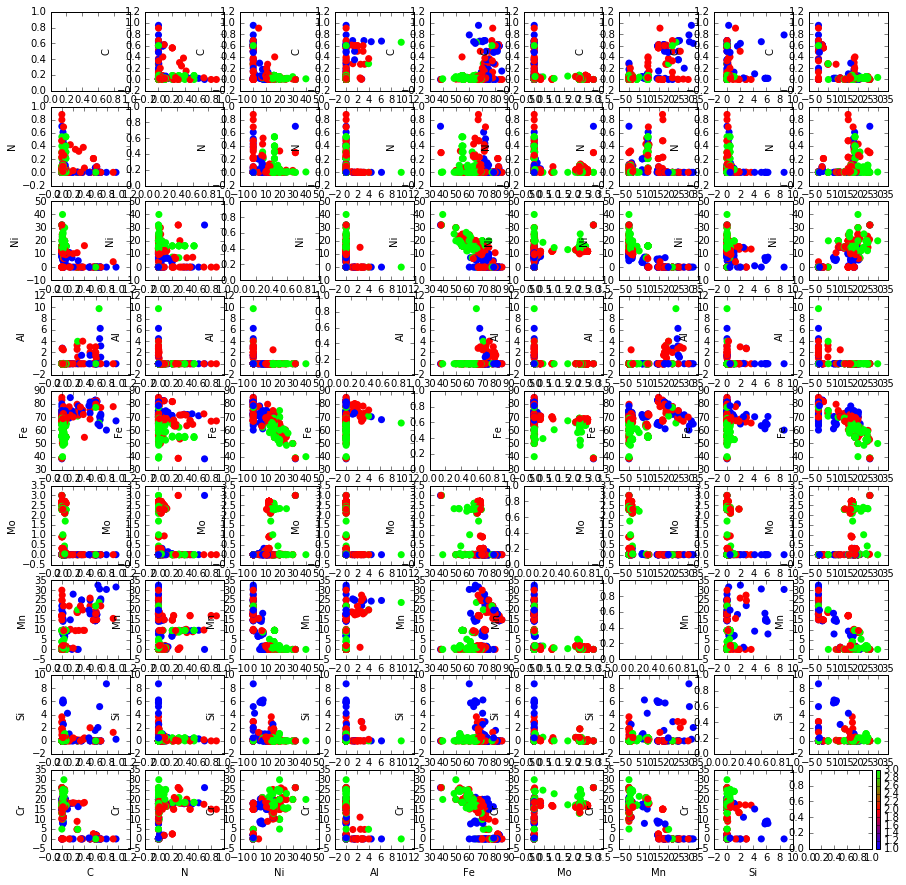

In [31]:
fig = plt.figure(figsize=(15,15))
iterarr = range(1,10)
for i in iterarr:
    for j in iterarr:
        ax = fig.add_subplot(len(iterarr),len(iterarr),(len(iterarr)*(i-1))+j)
        if (i!=j):
            cax = ax.scatter(Elements[:,j],Elements[:,i], c=SFEclass, marker="o", s=50, edgecolor='', cmap ='brg')
            ax.set_xlabel(Elementlist[j-1])
            ax.set_ylabel(Elementlist[i-1])
fig.colorbar(cax)
    
plt.show()
#plt.savefig('fig')

As one looks through the above scatterplot matrix, the same idea stands out as explained up untill now. There are no glaring patterns which standout regarding elemental compostion - SFE classes. The 3 classes are sprayed all over the plots more or less and thus we have reinforced the following fact strongly:

*SFE - composition is a highly non-linear relationship with many interaction effects*

**Functions for normalization and standardization**

In [32]:
def arraynorm(array,axis):
    minaxis = np.nanmin(array,axis)
    maxaxis = np.nanmax(array,axis)
    diffaxis = maxaxis - minaxis
    output = np.true_divide(array-minaxis,diffaxis)
    return output

def arraystandardize(array,axis):
    meanaxis = np.mean(array,axis)
    stdaxis = np.std(array,axis)
    output = np.true_divide(array-meanaxis,stdaxis)
    return output

In [33]:
NormElements = arraynorm(Elements[:,:],0)
StdElements = arraystandardize(Elements[:,:],0)
SFEclassint = np.array(SFEclass, dtype='int')

## Dimensionality Reduction for visualization and pattern recognition

In above all visualizations, we were restricted by the number of dimensions we could visualize simultaneously. We have 9 predictor variables(the element compositions) and one output variable (SFE class). Thus we ideally want 10 dimensions to visualize everything going on.

In such a situation, we leverage dimensionality reduction tehniques (linear & non-linear) to try and represent the 9 dimensional data in a lower 2 or 3 dimensional representation while preserving the true patterns in the data as far as possible.

** Principal Component Analysis **

explained variance ratio (first three components): [ 0.45279122  0.21611279  0.13709343]
total variance explained(first three components): 0.805997435643


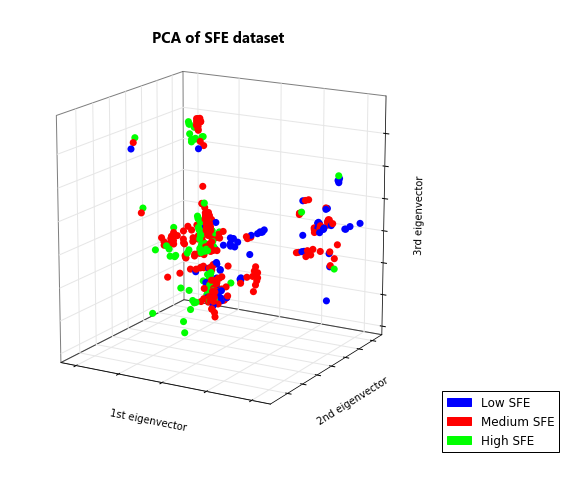

In [34]:
#PCA

from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(NormElements)

pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(NormElements)
var = math.floor(sum(pca_3.explained_variance_ratio_)*100)

print 'explained variance ratio (first three components): %s' % str(pca_3.explained_variance_ratio_)
print  'total variance explained(first three components): %s' %sum(pca_3.explained_variance_ratio_)

my_labels = ['Low SFE', 'Medium SFE', 'High SFE']


fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(1, 2,width_ratios=[10,2])
ax1 = plt.subplot(gs[0], projection='3d')
ax2 = plt.subplot(gs[1])


cax= ax1.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], s=50, c=SFEclass ,  edgecolor='', cmap='brg', depthshade=False)
#for i in range(0,len(X_pca_3)):
#    ax.text(X_pca_3[i,0], X_pca_3[i,1], X_pca_3[i,2],  '%s' % (str(i)), size=10 ,zorder=1, color='y') 
ax1.set_title("PCA of SFE dataset", fontweight='bold', fontsize=15, fontname='Segoe UI')
ax1.set_xlabel("1st eigenvector")
ax1.set_xlim(X_pca_3[:,0].min()-0.1,X_pca_3[:,0].max()+0.1)
ax1.w_xaxis.set_ticklabels([])
ax1.set_ylabel("2nd eigenvector")
ax1.set_ylim(X_pca_3[:,1].min()-0.1,X_pca_3[:,1].max()+0.1)
ax1.w_yaxis.set_ticklabels([])
ax1.set_zlabel("3rd eigenvector")
ax1.set_zlim(X_pca_3[:,2].min()-0.1,X_pca_3[:,2].max()+0.1)
ax1.w_zaxis.set_ticklabels([])
ax1.view_init(15,120)
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.zaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')
plt.axis('off')
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower right')

#plt.savefig('PCA3.png',format='png',dpi=500,bbox_inches='tight')
plt.show()

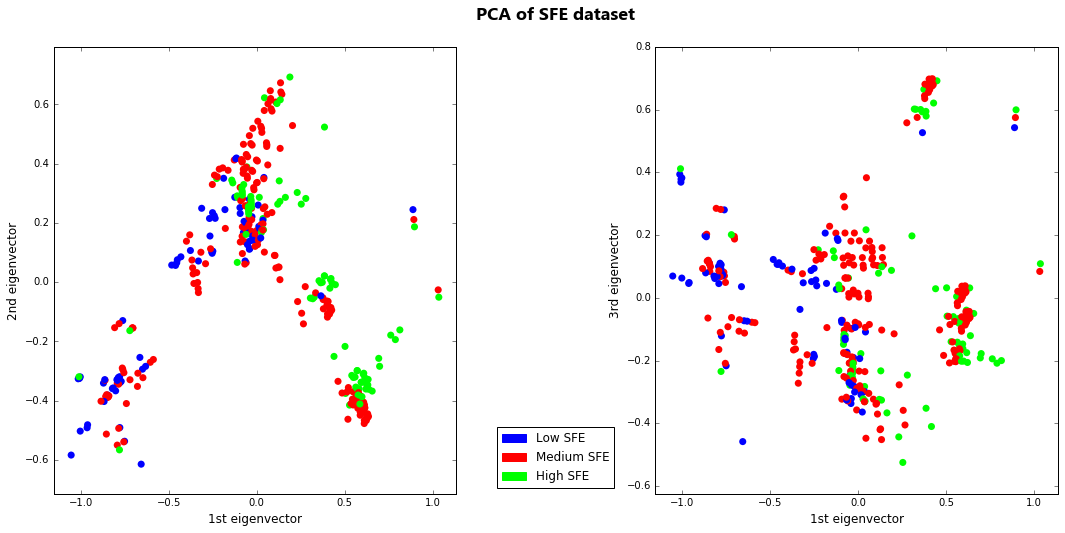

In [35]:
fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(1, 3,width_ratios=[10,2,10])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],frameon=False)
ax3 = plt.subplot(gs[2])

ax1.scatter(X_pca_3[:, 0], X_pca_3[:, 1], s=50, c=SFEclass, cmap='brg', edgecolor='')
#ax1.set_title("PCA of SFE dataset", fontweight='bold', fontsize=15, fontname='Segoe UI')
ax1.set_xlabel("1st eigenvector", fontsize=12)
ax1.set_xlim(X_pca_3[:,0].min()-0.1,X_pca_3[:,0].max()+0.1)
#ax1.xaxis.set_ticklabels([])
ax1.set_ylabel("2nd eigenvector", fontsize=12)
ax1.set_ylim(X_pca_3[:,1].min()-0.1,X_pca_3[:,1].max()+0.1)
#ax1.yaxis.set_ticklabels([])

ax3.scatter(X_pca_3[:, 0], X_pca_3[:, 2], s=50, c=SFEclass, cmap='brg', edgecolor='')
#ax3.set_title("PCA of SFE dataset", fontweight='bold', fontsize=15, fontname='Segoe UI')
ax3.set_xlabel("1st eigenvector", fontsize=12)
ax3.set_xlim(X_pca_3[:,0].min()-0.1,X_pca_3[:,0].max()+0.1)
#ax3.xaxis.set_ticklabels([])
ax3.set_ylabel("3rd eigenvector", fontsize=12)
ax3.set_ylim(X_pca_3[:,2].min()-0.1,X_pca_3[:,2].max()+0.1)
#ax3.yaxis.set_ticklabels([])

blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')

ax2.set_title("PCA of SFE dataset", fontweight='heavy', fontsize=18, fontname='Segoe UI')
ax2.title.set_position([0.5,1.05])
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower center')
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
#plt.axis('off')

#plt.savefig('PCA2.png',dpi=500)
plt.show()

Thus from the above plots of visualization after PCA reaffirm how the classes are mixed. However if we look closely at the above two 2-d figures we see some sort of pattern emerge. 

Let's see the same plots above with some markers added.

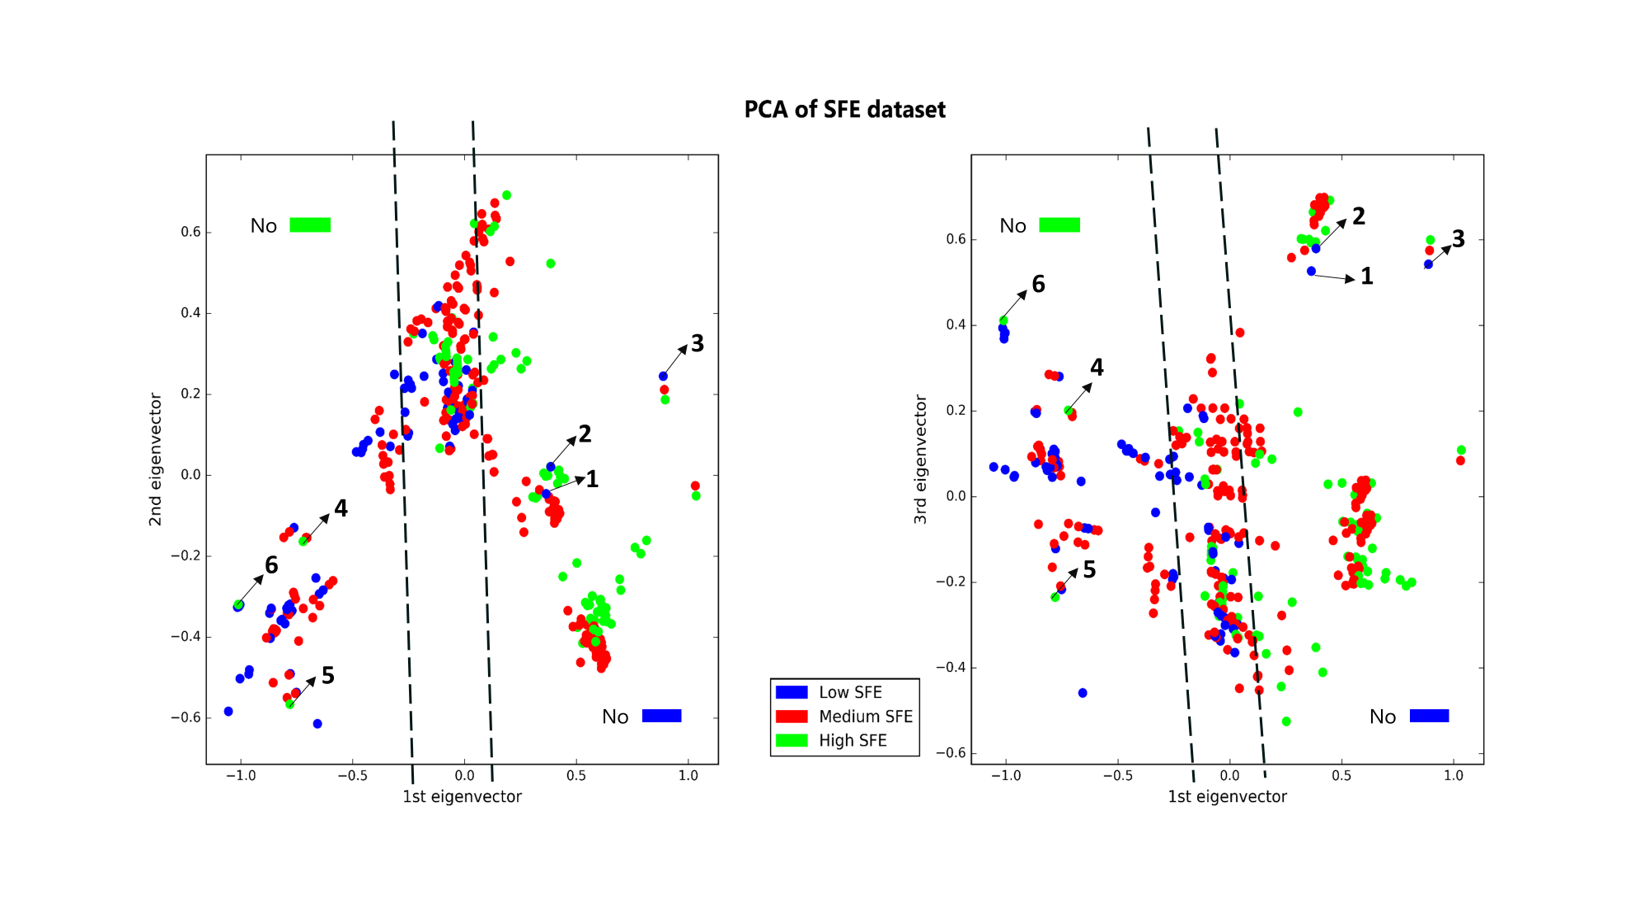

In [312]:
Image(filename='PCA_boundaries.png')

On the left plot, if we look along the x-axis (1st eigenvector) we see a separation between the *low* and *high* SFE classes.
For lower values of 1st eigenvector (~<0.25) we only have *red* and *blue* points, i.e. *medium* and *low* SFE classes. Similarly for higher values of 1st eigenvector(~>0.1) we only have *red* and *green* points, i.e *medium* and *high* SFE classes.

We can see similar pattern but flipped in the plot on the right above.

A more detailed discussion is done in the journal paper.

**Note: Point 2 which you see in the image but not in the plot generated above is an outlier which was incorrectly entered data as discussed in the paper. It was corrected at the source and hence is not seen in the plot generated above. More details in the paper**

Below we confirm our visual insights by checking the values in the initial dataset - checking for values on the left part of the left plot.

In [36]:
## sandbox cell for checking values from PCA
checkarray = np.where((X_pca_3[:,0]>0.1))
#print checkarray
print ini_dataset_5[[0,1,2,3,4,5,6,7,8,9]].iloc[checkarray]

          C       N     Ni  Al       Fe    Mo     Mn     Si     Cr     SFE
sno                                                                       
1    0.0040  0.0030  15.60   0  64.3170  2.50  0.030  0.020  17.50   51.60
2    0.0200  0.0090  15.60   0  64.1880  2.50  0.030  0.030  17.60   54.60
3    0.0200  0.0020  14.00   0  66.4090  2.40  0.030  0.010  17.10   50.30
4    0.0050  0.0010  15.60   0  63.8660  2.60  0.190  0.010  17.70   52.80
7    0.0030  0.0040  12.10   0  68.2320  2.60  0.020  0.014  17.00   42.00
8    0.0090  0.0030  12.20   0  68.0160  2.70  0.030  0.016  17.00   42.50
9    0.0180  0.0040  12.00   0  68.3050  2.70  0.030  0.014  16.90   42.10
10   0.0460  0.0040  11.90   0  68.5620  2.70  0.030  0.030  16.70   41.80
11   0.0750  0.0030  12.00   0  68.2360  2.60  0.030  0.030  17.00   41.80
12   0.0030  0.0130  12.00   0  68.4110  2.60  0.030  0.015  16.90   41.40
13   0.0030  0.0230  12.00   0  68.2260  2.70  0.030  0.190  16.80   41.60
14   0.0030  0.0610  12.1

Below we confirm our visual insights by checking the values in the initial dataset - checking for values on the right part of the left plot.

In [37]:
#sandbox cell for checking values from PCA
checkarray = np.where((X_pca_3[:,0]<-0.25))
#print checkarray
print ini_dataset_5[[0,1,2,3,4,5,6,7,8,9]].iloc[checkarray]

          C       N     Ni     Al       Fe    Mo      Mn     Si     Cr     SFE
sno                                                                           
34   0.6900  0.0000   0.00  1.160  72.2500  0.00  25.590  0.000   0.00   7.750
35   0.6900  0.0000   0.00  3.160  71.1800  0.00  24.750  0.000   0.00  10.670
36   0.6700  0.0000   0.00  4.450  70.3100  0.00  24.470  0.000   0.00  15.120
37   0.6800  0.0000   0.00  6.270  68.1000  0.00  24.800  0.000   0.00  14.950
38   0.6600  0.0000   0.00  9.770  65.5400  0.00  23.780  0.000   0.00  54.740
52   0.0093  0.0000   0.00  2.760  72.1107  0.00  22.200  2.920   0.00  15.000
53   0.0053  0.0000   0.00  2.660  69.6847  0.00  24.700  2.950   0.00  21.000
54   0.0071  0.0000   0.00  2.740  66.8629  0.00  27.500  2.890   0.00  38.500
59   0.0600  0.2400   7.46  0.000  64.7610  0.00   8.960  0.240  18.20  33.000
86   0.2800  0.0000   0.00  1.190  74.9700  0.00  18.800  0.000   4.76  20.900
87   0.2700  0.0000   0.00  2.550  72.8900  0.00  19

**Multidimensional Scaling**

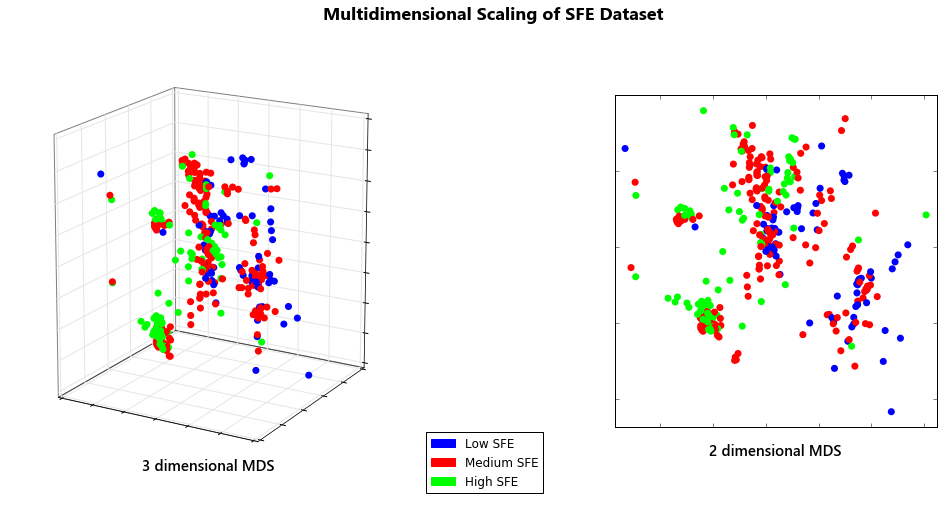

In [38]:
from sklearn import manifold


mds3Norm = manifold.MDS(n_components=3, eps = 1e-6, n_init = 3, random_state = 20)
mds3NormY = mds3Norm.fit_transform(NormElements)

mds2Norm = manifold.MDS(n_components=2, eps = 1e-6, n_init = 3, random_state = 20)
mds2NormY = mds2Norm.fit_transform(NormElements)

fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(20, 5,width_ratios=[10,2,.5,8,1])
fig.suptitle("Multidimensional Scaling of SFE Dataset", fontweight='bold', fontsize=18, fontname='Segoe UI')
plt.subplots_adjust(top=.95)

ax1 = plt.subplot(gs[:20,0], projection='3d')
ax2 = plt.subplot(gs[:20,1],frameon=False)
ax3 = plt.subplot(gs[3:17,3])

ax1.scatter( mds3NormY[:, 0], mds3NormY[:, 1], mds3NormY[:, 2], c = SFEclass, s =50,  edgecolor='', depthshade=False, cmap='brg')
ax1.set_title("3 dimensional MDS", fontweight='normal', fontsize=15, fontname='Segoe UI')
ax1.title.set_position([0.5,0.05])
ax1.xaxis.set_major_formatter(NullFormatter())
ax1.yaxis.set_major_formatter(NullFormatter())
ax1.zaxis.set_major_formatter(NullFormatter())
ax1.view_init(15,120)
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.zaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False



ax3.scatter( mds2NormY[:, 0], mds2NormY[:, 1], c = SFEclass, s =50,  edgecolor='', cmap='brg')
ax3.set_xlim(mds2NormY[:,0].min()-0.1,mds2NormY[:,0].max()+0.1)
ax3.set_ylim(mds2NormY[:,1].min()-0.1,mds2NormY[:,1].max()+0.1)
ax3.set_title("2 dimensional MDS", fontweight='normal', fontsize=15, fontname='Segoe UI')
ax3.title.set_position([0.5,-0.1])
ax3.xaxis.set_major_formatter(NullFormatter())
ax3.yaxis.set_major_formatter(NullFormatter())
#ax3.zaxis.set_major_formatter(NullFormatter())
#fig.colorbar(cax)

blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')

#ax2.set_title("Multidimensional Scaling of SFE dataset", fontweight='heavy', fontsize=18, fontname='Segoe UI')
ax2.title.set_position([0.5,1.05])
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower center')
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

#plt.savefig('MDS.png',dpi=500)
plt.show()

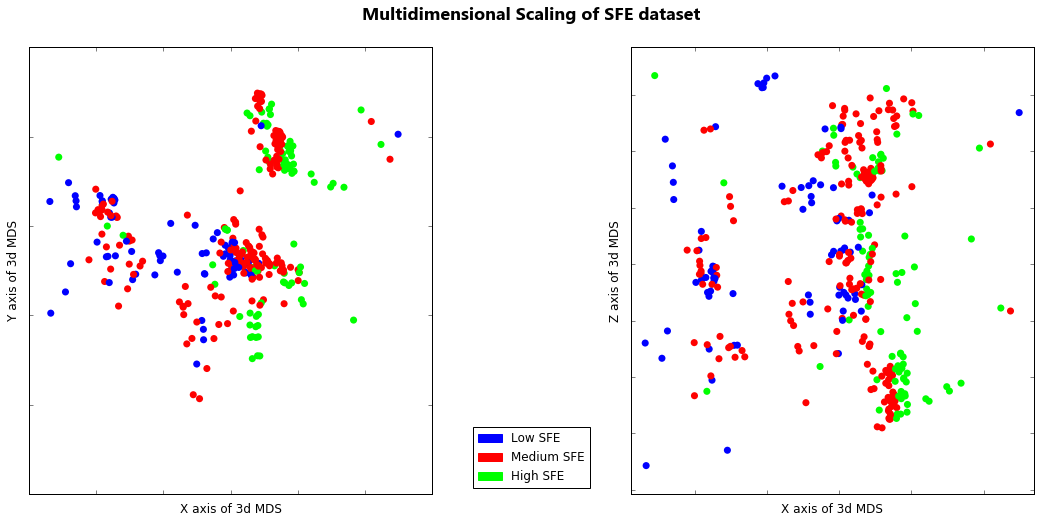

In [39]:
fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(10, 3,width_ratios=[10,2,10])
#fig.suptitle("Multidimensional Scaling of SFE Dataset", fontweight='bold', fontsize=18, fontname='Segoe UI')
#plt.subplots_adjust(top=.95)

ax1 = plt.subplot(gs[:10,0])
ax2 = plt.subplot(gs[:10,1],frameon=False)
ax3 = plt.subplot(gs[:10,2])

ax1.scatter( mds3NormY[:, 0], mds3NormY[:, 1], c = SFEclass, s =50,  edgecolor='', cmap='brg')
ax1.set_xlabel("X axis of 3d MDS", fontsize=12)
ax1.set_ylabel("Y axis of 3d MDS", fontsize=12)
ax3.set_xlim(mds3NormY[:,0].min()-0.1,mds3NormY[:,0].max()+0.1)
ax3.set_ylim(mds3NormY[:,1].min()-0.1,mds3NormY[:,1].max()+0.1)
#ax1.set_title("3 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
#ax1.title.set_position([0.5,0.05])
ax1.xaxis.set_major_formatter(NullFormatter())
ax1.yaxis.set_major_formatter(NullFormatter())




ax3.scatter( mds3NormY[:, 0], mds3NormY[:, 2], c = SFEclass, s =50,  edgecolor='', cmap='brg')
ax3.set_xlabel("X axis of 3d MDS", fontsize=12)
ax3.set_ylabel("Z axis of 3d MDS", fontsize=12)
ax3.set_xlim(mds3NormY[:,0].min()-0.1,mds3NormY[:,0].max()+0.1)
ax3.set_ylim(mds3NormY[:,2].min()-0.1,mds3NormY[:,2].max()+0.1)
#ax3.set_title("2 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
#ax3.title.set_position([0.5,-0.1])
ax3.xaxis.set_major_formatter(NullFormatter())
ax3.yaxis.set_major_formatter(NullFormatter())
#ax3.zaxis.set_major_formatter(NullFormatter())
#fig.colorbar(cax)

blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')

ax2.set_title("Multidimensional Scaling of SFE dataset", fontweight='heavy', fontsize=18, fontname='Segoe UI')
ax2.title.set_position([0.5,1.05])
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower center')
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

#plt.savefig('MDS2.png',dpi=500)
plt.show()

Hence we see patterns and results very similar to PCA !

**Locally Linear Embedding**

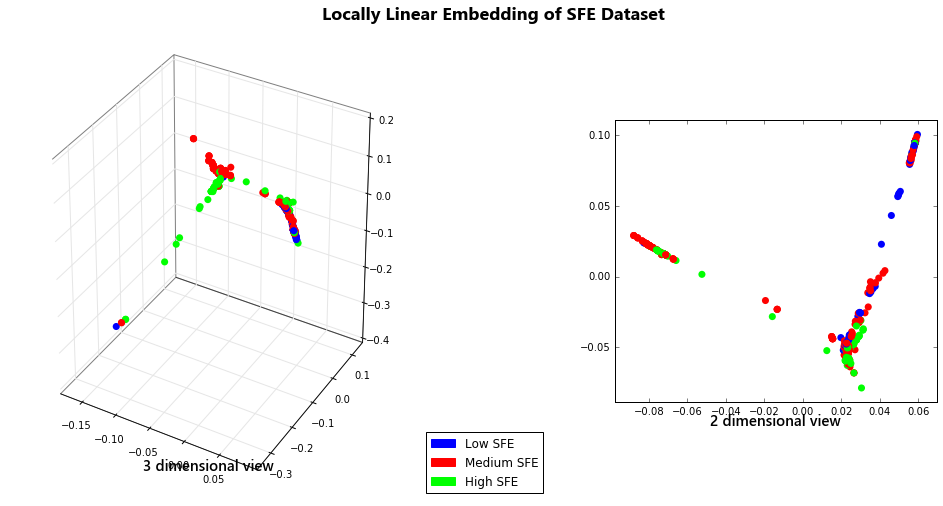

In [40]:
n_neighbors = 20

NormElements = arraynorm(Elements[:,1:],0)
LLEY_3 = manifold.LocallyLinearEmbedding(n_neighbors, n_components=3,
                                        eigen_solver='dense',
                                        method='modified').fit_transform(NormElements)

LLEY_2 = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                        eigen_solver='dense',
                                        method='modified').fit_transform(NormElements)

fig = plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(10, 5,width_ratios=[10,2,.5,8,1])
fig.suptitle("Locally Linear Embedding of SFE Dataset", fontweight='bold', fontsize=18, fontname='Segoe UI')
plt.subplots_adjust(top=.95)

ax1 = plt.subplot(gs[:10,0], projection='3d')
ax2 = plt.subplot(gs[:10,1],frameon=False)
ax3 = plt.subplot(gs[2:8,3])

ax1.scatter( LLEY_3[:, 0], LLEY_3[:, 1], LLEY_3[:, 2], c = SFEclass, s =50,  edgecolor='', depthshade=False, cmap='brg')
ax1.set_title("3 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
ax1.title.set_position([0.5,0.05])
ax1.set_xlim(LLEY_3[:,0].min()-0.01,LLEY_3[:,0].max()+0.01)
ax1.set_ylim(LLEY_3[:,1].min()-0.01,LLEY_3[:,1].max()+0.01)
ax1.set_ylim(LLEY_3[:,2].min()-0.01,LLEY_3[:,2].max()+0.01)
#ax1.xaxis.set_major_formatter(NullFormatter())
#ax1.zaxis.set_major_formatter(NullFormatter())
#ax1.view_init(15,120)
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.zaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False



ax3.scatter(LLEY_2[:, 0], LLEY_2[:, 1], c = SFEclass, s =50,  edgecolor='', cmap='brg')
ax3.set_xlim(LLEY_2[:,0].min()-0.01,LLEY_2[:,0].max()+0.01)
ax3.set_ylim(LLEY_2[:,1].min()-0.01,LLEY_2[:,1].max()+0.01)
ax3.set_title("2 dimensional view", fontweight='normal', fontsize=15, fontname='Segoe UI')
ax3.title.set_position([0.5,-0.1])
#ax3.xaxis.set_major_formatter(NullFormatter())
#ax3.yaxis.set_major_formatter(NullFormatter())
#ax3.zaxis.set_major_formatter(NullFormatter())
#fig.colorbar(cax)

blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')

#ax2.set_title("Multidimensional Scaling of SFE dataset", fontweight='heavy', fontsize=18, fontname='Segoe UI')
#ax2.title.set_position([0.5,1.05])
ax2.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower center')
#ax2.xaxis.set_major_formatter(plt.NullFormatter())
#ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

#plt.savefig('LLE.png',dpi=500)
plt.show()

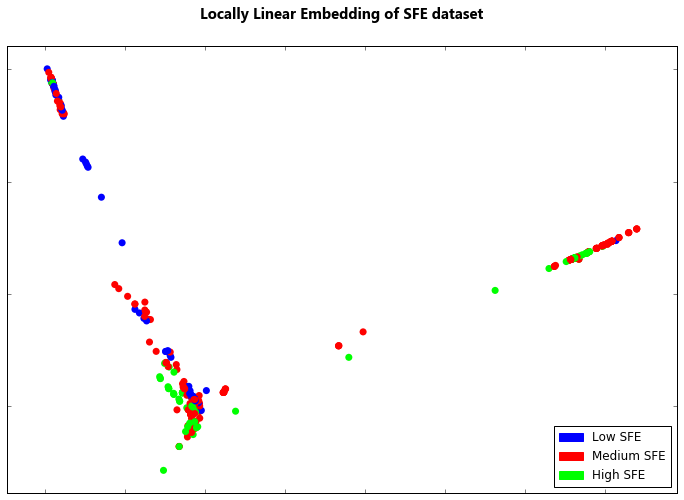

In [41]:
fig = plt.figure(figsize= (12,8))
ax= fig.add_subplot(1,1,1)
ax.scatter( LLEY_2[:, 0], LLEY_2[:, 1], c = SFEclass, s =50,  edgecolor='', cmap='brg' )
ax.set_xlim(LLEY_2[:,0].max()+0.01,LLEY_2[:,0].min()-0.01,)
#ax.set_ylim(LLEY_2[:,1].max()+0.01,LLEY_2[:,1].min()-0.01,)
ax.set_ylim(LLEY_2[:,1].min()-0.01,LLEY_2[:,1].max()+0.01)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
blue_patch = mpatches.Patch(color=[0,0,1], label='Low SFE')
red_patch = mpatches.Patch(color=[1,0,0], label='Medium SFE')
green_patch = mpatches.Patch(color=[0,1,0], label='High SFE')
ax.legend(handles=[blue_patch,red_patch,green_patch ], loc='lower right')
ax.set_title("Locally Linear Embedding of SFE dataset", fontweight='bold', fontsize=15, fontname='Segoe UI')
ax.title.set_position([0.5,1.05])

#plt.savefig('LLE.png',dpi=500)
plt.show()

In [108]:
#print ini_dataset_5.iloc[[37,57,88,172,178,179,180,181,219,220,221,222,223,234,235,236,237,246,256,258,267,269,283]]

** Changes to outliers as per Visualization **

In [42]:
print SFEclass [[54,57,88,246,283]]

[ 1.  3.  3.  3.  3.]


In [43]:
SFEclass[[54,57,88,246,283]]=[2.,2.,2.,2.,2.]

## Classification

This is where we build and compare models to choose the one best fitting our case.

For testing and selecting the model, we need an unseen test set. Hence we take our data and split it into an 80:20::train:test sets. We will build our models on the training set and then test their performance on "unseen" test set to finally select our best performing (one that generalizes well to unseen data) model.

In [44]:
#defining master indices
master_indices = np.arange(NormElements.shape[0])
print 'master indices shape : ', master_indices.shape

#choosing test set and corressponding training set
np.random.seed(25)
test_prop = 0.2
test_indices = np.random.choice(NormElements.shape[0],int(math.floor(test_prop*NormElements.shape[0])),replace = False)
test_x = NormElements[test_indices]
test_y = SFEclass[test_indices]

train_indices = master_indices
print 'train indices shape :', train_indices.shape
for item in test_indices:
    train_indices = np.delete(train_indices,np.where(train_indices==item))
print 'train indices shape  :', train_indices.shape

train_x = NormElements[train_indices]
train_y = SFEclass[train_indices]

master indices shape :  (374L,)
train indices shape : (374L,)
train indices shape  : (300L,)


In [45]:
#looking at the spread of class labels in training set

print "1",(SFEclass[train_indices,]==1).sum(),np.true_divide((SFEclass[train_indices,]==1).sum(),300)
print "2",(SFEclass[train_indices,]==2).sum(),np.true_divide((SFEclass[train_indices,]==2).sum(),300)
print "3",(SFEclass[train_indices,]==3).sum(),np.true_divide((SFEclass[train_indices,]==3).sum(),300)

1 58 0.193333333333
2 172 0.573333333333
3 70 0.233333333333


**Support Vector Machines**

Step 1 here is to select the best set of hyperparameters for our model. Since we will first select the model and then judge its accuracy using test set, we cannot use the test set to choose the hyperparameters as that means the test set is no longer "unseen" and has contributed to the fitting of the model.

Hence for hyperparameter selection, we do an n-fold cross validation on the training set itself to select the hyperparameters. Since our training set is relatively small and our experimental points are sparse, we need to choose a high value of 'n' in a hope that all cases are sampled well while training. 

In [46]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

#iterating over hyperparameters to select the best for our model
C_range = np.logspace(-2, 10, 10, base=2)
gamma_range = np.logspace(-9, 1, 5, base=2)
k_options = ['linear','poly','rbf']
params_grids = dict(gamma=gamma_range, C=C_range, kernel=k_options)
grid = GridSearchCV(SVC(), param_grid=params_grids, cv=30, n_jobs=10)
grid.fit(train_x,train_y)

print grid.best_params_
#grid.grid_scores_

{'kernel': 'poly', 'C': 1.5874010519681994, 'gamma': 2.0}


In [47]:
#training the model
clf_svc= SVC(kernel= 'poly', C= 1.5874, gamma = 2.0, random_state=25)
clf_svc.fit(train_x, train_y)
predict_y_svc = clf_svc.predict(test_x)

#testing model
from sklearn import metrics
model_score = clf_svc.score(test_x, test_y)
print ("Model Score for SVM on actual Data %.2f \n" % (model_score))

train_score = clf_svc.score(train_x, train_y)
print ("Model Score for SVM on training Data %.2f \n" % (train_score))

Model Score for SVM on actual Data 0.84 

Model Score for SVM on training Data 0.87 



In [54]:
#output various metrics

from sklearn.metrics import confusion_matrix
cm_svc = confusion_matrix(test_y,predict_y_svc)
print "Confusion Matrix \n",confusion_matrix(test_y,predict_y_svc),"\n"

from sklearn.metrics import precision_score
print "Precision scores across classes: ", precision_score(test_y,predict_y_svc,average=None), "\n"

from sklearn.metrics import recall_score
print "Recall scores across classes: ",recall_score(test_y,predict_y_svc,average=None), "\n"

from sklearn.metrics import precision_score
print "Macro Precision Score: ",precision_score(test_y,predict_y_svc,average='macro'), "\n"

from sklearn.metrics import recall_score
print "Macro Recall Score: ",recall_score(test_y,predict_y_svc,average='macro'), "\n"

Confusion Matrix 
[[13  5  0]
 [ 0 39  3]
 [ 1  3 10]] 

Precision scores across classes:  [ 0.92857143  0.82978723  0.76923077] 

Recall scores across classes:  [ 0.72222222  0.92857143  0.71428571] 

Macro Precision Score:  0.842529810615 

Macro Recall Score:  0.78835978836 



In [55]:
#getting percentage values for confusion matrix
np.true_divide(cm_svc,74)*100

array([[ 17.56756757,   6.75675676,   0.        ],
       [  0.        ,  52.7027027 ,   4.05405405],
       [  1.35135135,   4.05405405,  13.51351351]])

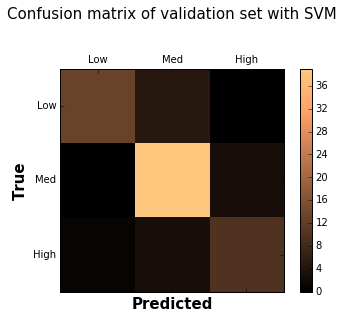

In [56]:
labels = ['Low', 'Med', 'High']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svc, cmap=plt.get_cmap('copper'))
ax.set_title('Confusion matrix of validation set with SVM', fontsize=15, x=0.5, y=1.2)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted', fontsize=15, fontweight = 'bold')
plt.ylabel('True', fontsize=15,  fontweight = 'bold')
plt.savefig("CM_SVC.png",format ='png', dpi=500, bbox_inches='tight',orientation='landscape')
plt.show()

**Random Forests**

Here we have similar steps as explained above for SVMs

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

#choosing the best set of hyperparameters
param_grid =  { "n_estimators" :[10,20,30,40,50],
                "max_features": [3,4,5]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=30, n_jobs=10)
grid_search.fit(train_x,train_y)

print grid_search.best_params_
#grid_search.grid_scores_

{'max_features': 5, 'n_estimators': 30}


In [58]:
#training the model
clf_rf = RandomForestClassifier(n_estimators=40,max_features=4,criterion='entropy', random_state=25)
clf_rf.fit(train_x, train_y)
predict_y_rf = clf_rf.predict(test_x)
predict_y_rf_prob = clf_rf.predict_proba(test_x)

#testing the model
from sklearn import metrics
model_score = clf_rf.score(test_x, test_y)
print ("Model Score for RF on actual Data %.2f \n" % (model_score))

train_score = clf_rf.score(train_x, train_y)
print ("Model Score for RF on training Data %.2f \n" % (train_score))

Model Score for RF on actual Data 0.85 

Model Score for RF on training Data 0.99 



In [63]:
#output various metrics

#importance of various predictor elements in determining SFE class as per RF
print Elementlist
print clf_rf.feature_importances_, "\n"

from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(test_y,predict_y_rf)
print "Confusion Matrix \n", confusion_matrix(test_y,predict_y_rf)

from sklearn.metrics import precision_score
print "Precision scores across classes: ", precision_score(test_y,predict_y_rf,average=None), "\n"

from sklearn.metrics import recall_score
print "Recall scores across classes: ", recall_score(test_y,predict_y_rf,average=None), "\n"

from sklearn.metrics import precision_score
print "Macro Precision score: ",precision_score(test_y,predict_y_rf,average='macro'), "\n"

from sklearn.metrics import recall_score
print "Macro Recall score: ", recall_score(test_y,predict_y_rf,average='macro'), "\n"

['C' 'N' 'Ni' 'Al' 'Fe' 'Mo' 'Mn' 'Si' 'Cr']
[ 0.06851121  0.09120391  0.30227987  0.02079805  0.2034679   0.05431281
  0.10603942  0.05668319  0.09670364] 

Confusion Matrix 
[[15  3  0]
 [ 1 38  3]
 [ 1  3 10]]
Precision scores across classes:  [ 0.88235294  0.86363636  0.76923077] 

Recall scores across classes:  [ 0.83333333  0.9047619   0.71428571] 

Macro Precision score:  0.838406691348 

Macro Recall score:  0.81746031746 



In [64]:
#getting percentage values for confusion matrix
np.true_divide(cm_rf,74)*100

array([[ 20.27027027,   4.05405405,   0.        ],
       [  1.35135135,  51.35135135,   4.05405405],
       [  1.35135135,   4.05405405,  13.51351351]])

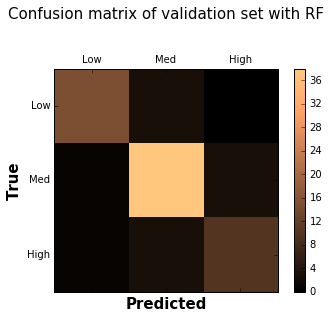

In [65]:
labels = ['Low', 'Med', 'High']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_rf, cmap=plt.get_cmap('copper'))
ax.set_title('Confusion matrix of validation set with RF', fontsize=15, x=0.5, y=1.2)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted', fontsize=15, fontweight = 'bold')
plt.ylabel('True', fontsize=15,  fontweight = 'bold')
plt.savefig("CM_RF.png",format ='png', dpi=500, bbox_inches='tight',orientation='landscape')
plt.show()

## Custom Error Metrics and Classification output

For a detailed understanding of this section, please read the journal paper. The basic idea is to exploit the nature of problem to predict more robustly, with some loss in predictive ability.

In [66]:
#defining the custom predition function

def custom_predict(predicted_prob,threshold):
    
    custom_prediction_array = np.zeros(predicted_prob.shape[0])
    
    for i in range(0,predicted_prob.shape[0]):
        for j in range(0,3):
            if predicted_prob[i,j] >= threshold:
                custom_prediction_array[i] = j+1
            
        if custom_prediction_array[i] == 0:
            if (predicted_prob[i,0]+predicted_prob[i,1]) > 0.7:
                custom_prediction_array[i] = 4
            elif (predicted_prob[i,1]+predicted_prob[i,2]) > 0.7:
                custom_prediction_array[i] = 5
            else:
                custom_prediction_array[i] = 0
        
    return custom_prediction_array 

In [67]:
#function for selection of probability

def choosing_prob(cust_pred_y):
    
    fuzzy_outputs = (sum(cust_pred_y==5) + sum(cust_pred_y==4))/cust_pred_y.shape[0]
    correct = 0
    for i in range(0,test_y.shape[0]):
        if test_y[i] == 1:
            if (cust_pred_y[i] == 1) | (cust_pred_y[i] == 4): correct += 1
        elif test_y[i] == 2:
            if (cust_pred_y[i] == 2) | (cust_pred_y[i] == 4) | (cust_pred_y[i]== 5): correct += 1
        elif test_y[i] == 3:
            if (cust_pred_y[i] == 3) | (cust_pred_y[i] == 5): correct += 1

    accuracy = correct/cust_pred_y.shape[0]
    
    return [accuracy*100, fuzzy_outputs*100]

In [68]:
#iterating over probability choices

probability_choices = [0.5, 0.6, 0.66, 0.7 ,0.8, 0.9]

for item in probability_choices:
    cust_pred_y = custom_predict(predict_y_rf_prob,item)
    print choosing_prob(cust_pred_y)

[85.13513513513513, 0.0]
[85.13513513513513, 1.3513513513513513]
[87.83783783783784, 9.4594594594594597]
[87.83783783783784, 13.513513513513514]
[93.24324324324324, 28.378378378378379]
[95.94594594594594, 47.297297297297298]


Thus based on the above output we choose a threshold probability of p=0.66 as our accuracy is still pretty high (88%) and we lose only 10% of predictions to "fuzzy classes". However we are ensuring there is atleast twice evidence of a class than any other class (p=0.66 is atleast twice of probability of any other class in the 3 class case). Thus our predictions are more robust than the default case of RF prediction.

## Validation and knowledge aquisition

In [69]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
normele = min_max_scaler.fit_transform(Elements[:,1:])

In [102]:
def predict_everything(test):
    norm_test = min_max_scaler.transform(test)
    predict_test = clf_rf.predict(norm_test)
    predict_test_prob = clf_rf.predict_proba(norm_test)
    predict_test_custom = custom_predict(predict_test_prob,0.66)
   
    return [predict_test, predict_test_prob, predict_test_custom]

In [71]:
Elementlist

array(['C', 'N', 'Ni', 'Al', 'Fe', 'Mo', 'Mn', 'Si', 'Cr'], dtype=object)

Below we randomly chose a journal paper which had certain austenitic steel compositions and their deformation behavior. Hence the paper exactly had the input and output of our model - bypassing the SFE mapping step. So we test our model on this "unseen" data to ascertain the quality of our predictions. More discussion in the paper.

In [104]:
sato = np.array([[0.07 , 0.0 , 0.0, 1.81 , 79.10, 0.0, 19.10, 0.14, 0],
        [0.05 , 0.0 , 0.0, 4.40 , 76.20, 0.0, 19.40, 0.03, 0],
        [0.07 , 0.0 , 0.0, 0.00 , 68.70, 0.0, 31.30, 0.08, 0],
        [0.07 , 0.0 , 0.0, 2.05 , 68.80, 0.0, 29.14, 0.11, 0],
        [0.06 , 0.0 , 0.0, 3.81 , 67.00, 0.0, 29.18, 0.11, 0],
        [0.07 , 0.0 , 0.0, 7.15 , 64.00, 0.0, 28.80, 0.05, 0]])

In [107]:
predict_everything(sato)[2]

array([ 2.,  2.,  4.,  2.,  2.,  4.])

## Testing your composition

In [76]:
Elementlist

array(['C', 'N', 'Ni', 'Al', 'Fe', 'Mo', 'Mn', 'Si', 'Cr'], dtype=object)

Enter your composition here in the order given above !!

In [123]:
your_composition = np.array([0.06 , 0.0 , 0.0, 3.81 , 67.00, 0.0, 29.18, 0.11, 0])
your_composition

array([  6.00000000e-02,   0.00000000e+00,   0.00000000e+00,
         3.81000000e+00,   6.70000000e+01,   0.00000000e+00,
         2.91800000e+01,   1.10000000e-01,   0.00000000e+00])

In [125]:
import warnings
warnings.filterwarnings('ignore')

#your prediction
predict_everything(your_composition)[2]

array([ 2.])